# Pythonopdracht week 4: SIFT and RANSAC

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Utilities" data-toc-modified-id="Utilities-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Utilities</a></span></li><li><span><a href="#Overview" data-toc-modified-id="Overview-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Overview</a></span></li><li><span><a href="#Projective-Transform-and-Warping" data-toc-modified-id="Projective-Transform-and-Warping-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Projective Transform and Warping</a></span></li><li><span><a href="#Scale-Invariant-Feature-Transform-(SIFT)" data-toc-modified-id="Scale-Invariant-Feature-Transform-(SIFT)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Scale Invariant Feature Transform (SIFT)</a></span><ul class="toc-item"><li><span><a href="#SIFT-in-Theory" data-toc-modified-id="SIFT-in-Theory-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>SIFT in Theory</a></span></li><li><span><a href="#SIFT-in-Practice" data-toc-modified-id="SIFT-in-Practice-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>SIFT in Practice</a></span></li></ul></li><li><span><a href="#Matching-Descriptors" data-toc-modified-id="Matching-Descriptors-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Matching Descriptors</a></span></li><li><span><a href="#Random-Sample-Concensus-(RANSAC)" data-toc-modified-id="Random-Sample-Concensus-(RANSAC)-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Random Sample Concensus (RANSAC)</a></span><ul class="toc-item"><li><span><a href="#Ransac-for-Line-Fitting" data-toc-modified-id="Ransac-for-Line-Fitting-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Ransac for Line Fitting</a></span></li><li><span><a href="#Find-a-Perspective-Transform-using-Ransac" data-toc-modified-id="Find-a-Perspective-Transform-using-Ransac-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Find a Perspective Transform using Ransac</a></span></li></ul></li><li><span><a href="#Sztitching-it-all-together" data-toc-modified-id="Stitching-it-all-together-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Stitching it all together</a></span></li><li><span><a href="#(Bonus)-A-Better-Stitch" data-toc-modified-id="(Bonus)-A-Better-Stitch-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>(Bonus) A Better Stitch</a></span></li><li><span><a href="#(Bonus)-Stitching-your-own-Images" data-toc-modified-id="(Bonus)-Stitching-your-own-Images-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>(Bonus) Stitching your own Images</a></span></li></ul></div>

## Initialization

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import wget
from skimage.transform import warp
import scipy
import cv2
from matplotlib.patches import ConnectionPatch

<class 'ModuleNotFoundError'>: No module named 'wget'

This week, we are working with SIFT. For this we need the right version of the `opencv` package. Did you do assignment 0 of week 1, about installing the correct version? If not, go do that now. You can try `conda install -c conda-forge opencv-contrib-python`,`python3 -m pip install --user opencv-contrib-python`, or `pip install opencv-python-headless`. If you have difficulties with installation, please refer to your TA.

Hidden in this cell are some $\LaTeX$ macros
$\newcommand{\v}[1]{\mathbf #1}$
$\newcommand{\hv}[1]{\widetilde{\mathbf #1}}$
$\newcommand{\setR}{\mathbb R}$
$\newcommand{\T}{^\top}$
$\newcommand{\inv}{^{-1}}$
$\newcommand{\pfrac}[2]{\frac{\partial #1}{\partial #2}}$

## Utilities

In this section there is some code that is needed later on in this exercise. Make sure this code is executed before using it.

In [ ]:
def imshow_row(imttllist, axs=False):
    n = len(imttllist)
    for i, imttl in enumerate(imttllist):
        if imttl is None:
            continue
        im, ttl = imttl
        plt.subplot(1,n,i+1)
        plt.imshow(im, cmap='gray')
        if not axs:
            plt.axis('off')
        plt.title(ttl)

def draw_keypoints(kps, nkps=None, ax=None, marker='x', 
                   marker_size=10, scale_and_orientation=True):
    if ax is None:
        ax = plt.gca()
    if nkps is None:
        nkps = len(kps)
    xs = [kp.pt[0] for kp in kps]
    ys = [kp.pt[1] for kp in kps]
    ax.scatter(xs, ys, marker=marker)
    if scale_and_orientation:
        for kp in kps[:nkps]:
            x, y = kp.pt
            r = kp.size / 2
            angle = kp.angle/2/np.pi
            ax.add_artist(plt.Circle((kp.pt), kp.size/2, 
                                     color='green', fill=False))
            ax.add_artist(plt.Arrow(x, y, r*np.cos(angle), 
                                    r*np.sin(angle), color='red'))



def draw_matches(f1, kps1, f2, kps2, matches, 
                 horizontal=True, figsize=(15,15)):
    if horizontal:
        fig, axs = plt.subplots(1,2, figsize=figsize)
    else:
        fig, axs = plt.subplots(2,1, figsize=figsize)
    
    axs[0].imshow(f1)
    axs[1].imshow(f2)
    
    # get the indexes of the matches
    idx1 = [m.queryIdx for m in matches]
    idx2 = [m.trainIdx for m in matches]
    
    xs1 = [kps1[i].pt[0] for i in idx1]
    ys1 = [kps1[i].pt[1] for i in idx1]
    xs2 = [kps2[i].pt[0] for i in idx2]
    ys2 = [kps2[i].pt[1] for i in idx2]
    
    
    for x1, y1, x2, y2 in zip(xs1, ys1, xs2, ys2):
        con = ConnectionPatch(xyA=(x1, y1), xyB=(x2, y2), coordsA="data", coordsB="data",
                      axesA=axs[0], axesB=axs[1], color='g')
        axs[1].add_artist(con)            

## Overview

The goal of this project is to write the software to stitch two or more images of the same scene together. In this report we describe the process of stitching only two images together. The basic steps of the algorithm are:
 
1. **Locate keypoints** in both images. A keypoint is defined by its position $(x,y)$ in the image, the scale $s$ at which it is detected, its orientation $\theta$ and a descriptor $\v d$ that characterizes what the image looks like in the neighborhood of the keypoint.

1. **Match the keypoints** in both images. A pair $((x,y,\theta,\v d), (x',y',\theta',\v d')$ (the primed keypoint is in image 2, the other keypoint is in image 1) matches when $\|\v d - \v d'\|$ is small enough to conclude that image 1 around point $(x,y)$ is visually (almost) equal to image 2 around point $(x', y')$.

1. **Estimate the transformation** $P$ that maps points in image 1 to the corresponding points in image 2. Because not all found point matches from step 2 are correct we need a robust estimation procedure that is capable of selecting those matching pairs that are indeed related through the transform $P$. For this we will use the RANSAC procedure.

1. **Warp** both images to a common coordinate system, and display the result.

This is an assignment in which the SIFT part can be used from OpenCV (it would be too big), but RANSAC you are asked to implement yourself (not too hard, and instructive).

In this exercise we start with stitching two small views on Rembrandt's Nachtwacht into a common coordinate frame. The two images are stored as jpeg files on disk. So when reading these images they are represented as (M,N,3) shaped arrays of dtype=uint8. 

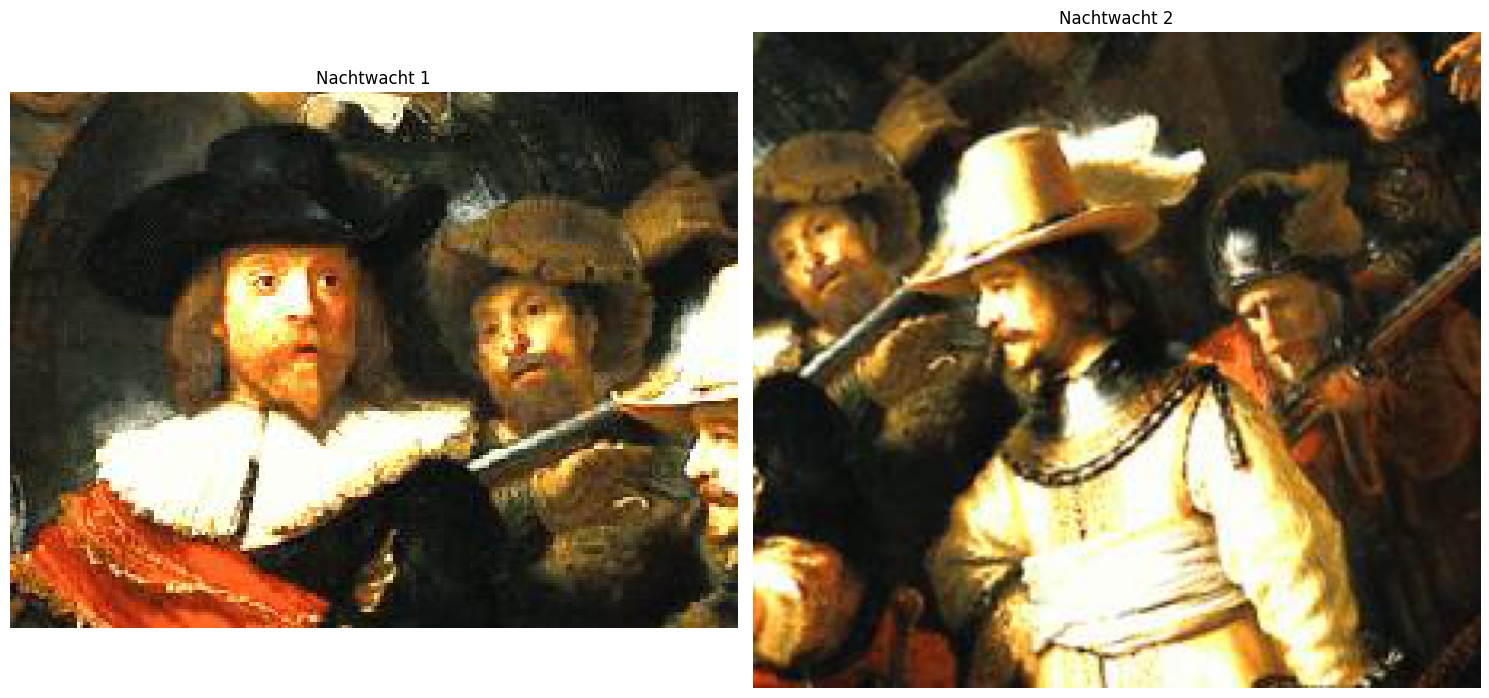

In [29]:
try:
    f1 = plt.imread('nachtwacht1.jpg')
except FileNotFoundError:
    wget.download("https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_images/nachtwacht1.jpg")
    f1 = plt.imread('nachtwacht1.jpg')
try:
    f2 = plt.imread('nachtwacht2.jpg')
except FileNotFoundError:
    wget.download("https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_images/nachtwacht2.jpg")
    f2 = plt.imread('nachtwacht2.jpg')
plt.figure(figsize=(15,15))
imshow_row([(f1, "Nachtwacht 1"),
            (f2, "Nachtwacht 2")])
plt.tight_layout()

Note that the scale of both images is different and also the orientation is slightly different. In fact, it will turn out that we really need a projective transform to relate the coordinate frames of these two images.

In this exercise we will proceed as follows:

1. Using 4 and 6 point correspondences in the images we test your 
   implementation of ``projective_transform_matrix``

1. Instead of manually selected point correspondences in both images 
   we will use SIFT and RANSAC to find the point correspondences 
   while at the same time estimating the projective transform.
   
   1. For SIFT we will use the OpenCV version, and
   
   1. For RANSAC you will have to implement your own version.
   
1. Then you have to make an image filled with zeros and warp both 
   nachtwacht images to the coordinate frame of the resulting image. 
   The new image should contain the two nachtwacht images completely 
   (note that this last requirement is not met within the first part 
   of this exercise)
      

## Projective Transform and Warping

In the nachtwacht1 and nachtwacht2 image we have manually picked 4 corresponding points, these are collected in the arrays ``xy`` and ``xaya``.

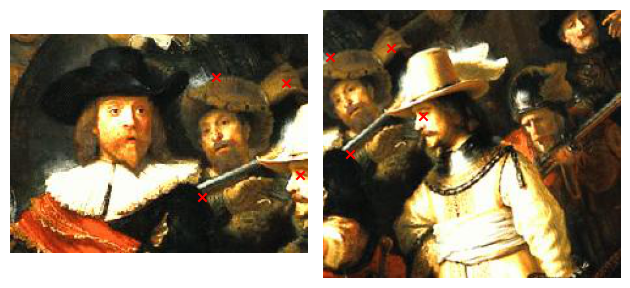

In [4]:
xy = np.array([[ 157, 32],
               [ 211, 37],
               [ 222,107],
               [ 147,124]])
xaya = np.array([[  6, 38],
                 [ 56, 31],
                 [ 82, 87],
                 [ 22,118]])
plt.subplot(1,2,1)
plt.imshow(f1)
plt.scatter(xy[:,0], xy[:,1], marker='x', color='r')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(f2)
plt.scatter(xaya[:,0], xaya[:,1], marker='x', color='r')
plt.axis('off')
plt.tight_layout()

From these point correpondences you can calculate the projective transform $P$ that maps coordinates in the first image to the corresponding coordinates in the right image. We will be using the functions ``projective_transform_matrix``, `e2h`, `h2e` from previous labs:

In [5]:
def projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4):
    M = np.empty((0,9))
    for (x, y), (xa, ya) in zip([x1, x2, x3, x4], [xa1, xa2, xa3, xa4]):
        M = np.append(M, 
                      np.array([[x, y, 1, 0, 0, 0, -xa*x, -xa*y, -xa],
                                [0, 0, 0, x, y, 1, -ya*x, -ya*y, -ya]]),
                      axis=0)
    _, _, VT = np.linalg.svd(M)
    p = VT[-1]
    P = p.reshape((3,3))
    return P

def e2h(x):
    if len(x.shape) == 1:
        return np.hstack((x, [1]))
    return np.vstack((x, np.ones(x.shape[1])))
    
def h2e(tx):
    return tx[:-1]/tx[-1]


In [6]:
P = projective_transform_matrix(xy[0], xy[1], xy[2], xy[3],
                           xaya[0], xaya[1], xaya[2], xaya[3])

In [7]:
f_stitched = warp(f2, P, output_shape=(300,450), preserve_range=True).astype(np.uint8)
plt.imshow(f_stitched);
plt.axis('off');
plt.tight_layout()

<class 'NameError'>: name 'warp' is not defined

In [8]:
M, N = f1.shape[:2]
f_stitched[:M, :N, :] = f1
plt.imshow(f_stitched);
plt.axis('off');
plt.tight_layout()

<class 'NameError'>: name 'f_stitched' is not defined

Be sure to understand what is going on in the code above. Can you explain why you didn't need the inverse of $P$ in the warp function?

Note that the stitching is not exactly perfect. You can clearly see the border of the first image. The reason is that our hand-picked points weren't perfect matches for the two images. We can improve by using more than four points to get a best fit for the handpicked correspondences. 

You have to change your ``projective_transform_matrix`` to be able to do the estimation of the projection matrix in case more than the minimal 4 point correspondences are given. Below we give 6 point correspondences:

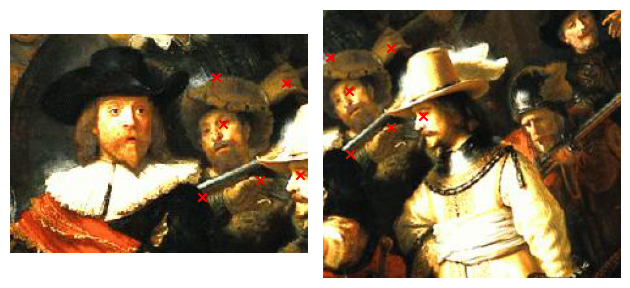

In [9]:
xy6 = np.array([[ 157, 32],
               [ 211, 37],
               [ 222,107],
               [ 147,124],
               [ 163, 68],
               [ 191,111]])
xaya6 = np.array([[  6, 38],
                 [ 56, 31],
                 [ 82, 87],
                 [ 22,118],
                 [ 21, 66],
                 [ 56, 96]])
plt.subplot(1,2,1)
plt.imshow(f1)
plt.scatter(xy6[:,0], xy6[:,1], marker='x', color='r')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(f2)
plt.scatter(xaya6[:,0], xaya6[:,1], marker='x', color='r')
plt.axis('off')
plt.tight_layout()

The function `projective_transform_matrix`, with as inputs four point correspondences, gives the unique projective mapping that maps those four point correspondences. Now you have to generalize the function: if you have more point correspondences, give the projective transformation which gives the closest possible approximation to the target points.

We call this function `projective_fit_model`, and have it take a single parameter `data`, which is an iterable of pairs of points -- these choices will make sense later in the notebook.

In [10]:
def projective_fit_model(data):
    """
    data is an iterable of pairs (input, output). Each pair consists of two Euclidean 2d vectors.
    
    Calculate the projection matrix P that maps all input points onto their corresponding output point,
    or as close as possible.
    
    data will have at least four pairs. If it has exactly four pairs it should behave the same as
    `projective_transform_matrix` (possibly up to a multiplicative constant):
    
        projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4) ==
            projective_fit_model([(x1, xa1), (x2, xa2), (x3, xa3), (x4, xa4)])
    """
    # YOUR CODE HERE (Replace this and the following line with your code)
    raise NotImplementedError()

In [11]:
P6 = projective_fit_model(zip(xy, xaya))

<class 'NotImplementedError'>: 

In [12]:
f_stitched6 = warp(f2, P6, output_shape=(300,450))
plt.imshow(f_stitched6);
plt.axis('off');
plt.tight_layout()

<class 'NameError'>: name 'warp' is not defined

In [13]:
M, N = f1.shape[:2]
f_stitched6[:M, :N, :] = f1/255.0 #rescaling f1 to play nice with the warp function
plt.imshow(f_stitched6);
plt.axis('off');
plt.tight_layout()

<class 'NameError'>: name 'f_stitched6' is not defined

Note that even 6 point correspondences that are manually selected do not result in good result (look at the white hat at the border of both images). In the sequel of this lab exercise SIFT/RANSAC will be used to automatically find corresponding points in both images with much better accuracy leading to better stitching results.

## Scale Invariant Feature Transform (SIFT)

We will use the SIFT algorithm from OpenCV. A quite complex algorithm using quite some clever 'tricks-of-the-(computer vision)-trade'. In case you are interested look at the [source code](https://github.com/opencv/opencv_contrib/blob/master/modules/xfeatures2d/src/sift.cpp) (yes this is really how messy computer vision code can get if you want to squeeze out every last bit of performance from your computer).

OpenCV encodes a color pixel with a BGR triple of values whereas Matplotlib and skimage use RGB triplets. That is why in the code below you see the cryptic ``f1[:,:,::-1]`` indexing.

In [14]:
fd = cv2.SIFT_create()
kp1, d1 = fd.detectAndCompute(f1[:,:,::-1], None)
kp2, d2 = fd.detectAndCompute(f2[:,:,::-1], None)
plt.figure(figsize=(15,15))
plt.imshow(f1)
draw_keypoints(kp1)
plt.axis('off')
plt.tight_layout()
plt.figure(figsize=(15,15))
plt.imshow(f2)
draw_keypoints(kp2)
plt.axis('off')
plt.tight_layout()

<class 'NameError'>: name 'cv2' is not defined

## Matching Descriptors

Now that you have computed the SIFT descriptors, you can use those to establish possible matches. Matching points (one keypoint in image 1 and one in image 2) are based on the similarity of the descriptors. So a keypoint 
$(x,y,s,\theta, \v d)$ in image 1 and a keypoint $(x',y',s',\theta',\v d')$ in image 2 are considered a match in case $\|\v d-\v d'\|$ is small.

We will use the 'brute force matcher' from OpenCV. It is a greedy algorithm: select the pair of keypoints, one from image 1 and one from image 2, with the minimal descriptor distance. This is the first match and these keypoints will not be considered again. Then you repeat the search and so on and so on, until you run out of descriptors in one of the two images.


In [15]:
matcher = cv2.BFMatcher()
matches = matcher.match(d1,d2)
matches = sorted(matches, key = lambda x: x.distance)

draw_matches(f1, kp1, f2, kp2, matches[:200], figsize=(15,15), horizontal=False)

<class 'NameError'>: name 'cv2' is not defined

Observe that you see a lot of 'wrong' matches in the above images. But are they really wrong? What is happening? Why do we find these 'wrong' matches? And what do we mean with 'wrong' really? 

These 'wrong' matches will be filtered out in the next section. The filtering will *not* be done based on visual appearance but on the possibility to find a common mapping of points in image 1 to the corresponding points in image 2.

In case you are interested in algorithms and datastructures it might be interesting to realize that such a brute force approach to matching (essentially the problem of finding closest points in high dimensional space, in our case $\v d\in\setR^{256}$) is rather slow. It turns out that a faster search for the closest point is not trivial. In OpenCV an *approximate* but faster algorithm is available.

## Random Sample Concensus (RANSAC)

RANSAC is a method to simulatenously estimate the parameters of a transformation given examples of (input, output) pairs while at the same time removing those pairs that are not related by the model (the *outliers*).

The RANSAC algorithm needs two functions ``fit_model`` and ``test_model`` and proceeds as follows:

1. The ``fit_model`` function takes a randomly selected list of ``n_model_data`` (input, output) pairs and estimates the parameters of the model, so that the model maps each of the inputs as close as possible to the corresponding outputs. Most often ``n_model_data`` is taken to be the minimum number of (input, output) pairs that allow the parameters to be calculated.

1. The ``test_model`` function tests a given model on all available (input, output) pairs. It selects those pairs that fit the model quite good (a threshold to be set by the programmer, depending on what model is being used) as the *inliers*.

1. The functions ``fit_model`` and ``test_model`` are called ``n_iter`` times each time with a random choice of ``n_model_data`` (input, output) pairs. The model with the most inliers is taken to be the optimal model.

1. Finally, the model parameters are then estimated once more, not with just the ``n_model_data`` pairs, but with all inliers for this model.

Read about the RANSAC algorithm (e.g. on Wikipedia) and complete the ``ransac`` function below. To see the ``ransac`` function in action (if you have completed the code, or when you are looking for an example in what way to write the ``fit_model`` and ``test_model`` function look at the subsequent section on line fitting with RANSAC.

Your RANSAC solution should be reasonably fast: the test cell below should run within a few seconds. One of the codegrade tests will call the function repeatedly to test both its speed and correctness.

Note that RANSAC is agnostic about the model type used, as long as it is consistent between the data and the functions `fit_model` and `test_model`. This allows us to write it once and use it on a variety of problems: in this notebook, line fitting and image alignment.

In [16]:
def ransac(data, fit_model, test_model, test_model_pars, 
           n_model_data, n_iter):
    """
    Use of RANSAC to fit a model to data
    
    Parameters
    ==========
    
    data: list
       each item in data is a tuple (input, output)
    fit_model: callable
       a function that takes data (a list of tuples of 
       (input, output) pairs) and returns an object describing 
       the fitted model
    test_model: callable
       a function that takes as first parameter the model 
       (return value of fit_model) and as second argument a list
       of (input, output) tuples (it expects all data tuples 
       including those used for the estimation). 
       It returns an array with the indices in the list of tuples 
       (second parameter) of all data tuples that fit the model 
       (i.e. the inliers)
    test_model_pars: dict
       a dictionary that is passed to the ``test_model`` function used to set
       a threshold to determine if an (input, output) pair is an inlier or not.
    n_model_data: int
       the number of data tuples to be used to fit the model
    n_iter: int
       number of iterations 
    
    
    Return Value
    ============
    (model, inliers): tuple
       model: the model, as returned by fit_model
       inliers: the indices of the inliers of the returned model 
           (not just the data points used to fit the model)
    """
    # YOUR CODE HERE (Replace this and the following line with your code)
    raise NotImplementedError()
    return (model, inliers)


### Ransac for Line Fitting

Let's try the RANSAC algorithm on the line fitting problem. Note: fitting a line is NOT what is needed in the image stitching problem! We start with it because it is an easier problem and more easily visualized. 

First we generate some noisy data. We generate random  𝑥  values in the range from 0 to 10. The majority of those  𝑥  values get an  𝑦  value (to generate the pair  (𝑥,𝑦) ) that is on a straight line but with a random error. The remaining  𝑥  values are given a random  𝑦 -value.

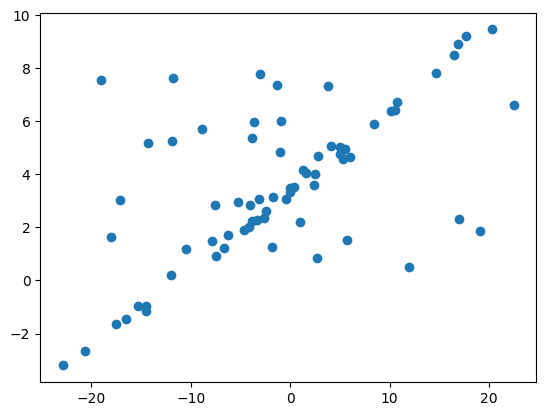

In [17]:
np.random.seed(7)
x = 10 * np.random.randn(70);
y = 0.3 * x + 3.4
y = y + 0.3 * np.random.randn(len(y))
y[40:] = 8 * np.random.rand(30)
plt.plot(x,y,'o');
data = list(zip(x,y)) # a list of pairs (input,output), 
                      # in this case (x,y) pairs

Given a number of $n>2$ pairs of points $(x,y)$ we can fit a line using a LSQ procedure:

In [18]:
def fit_line(data):
    """Fit a line to (x,y) pairs using a LSQ procedure"""
    X = np.array( [ [a, 1] for (a,b) in data])
    y = np.array( [ b for (a,b) in data])
    return np.linalg.lstsq(X, y, rcond=None)[0]

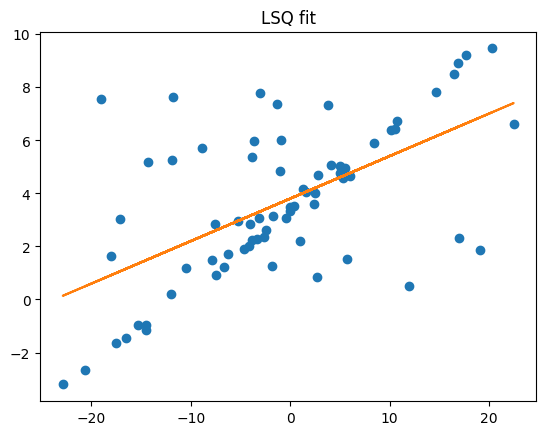

In [19]:
line_lsq = fit_line(data)
yfit_lsq = line_lsq[0]*x + line_lsq[1]
plt.plot(x,y,'o')
plt.plot(x,yfit_lsq)
plt.title('LSQ fit');

Evidently this is not the line we are looking for. We need to get rid of the outliers, i.e. the points $(x,y)$  that are not from the straight line. With the ``test_line`` function we can find the inliers for a given model.

In [20]:
def test_line(line, data, max_error=1):
    x = np.array( [ x for x, _ in data])
    y = np.array( [ y for _, y in data])
    yp = line[0]*x + line[1]
    err = np.abs(y-yp)
    inliers_idx = np.flatnonzero(err<max_error)
    return inliers_idx

In [ ]:
# Visual test (for the first test case below)

plt.figure(figsize=(10,10))
me = 0.7
line = None
inliers_idx = None
line, inliers_idx = ransac(data, fit_line, test_line, p
                           {'max_error':me}, 4, 1000)
plt.plot(x, y, 'o');
plt.plot(x[inliers_idx], y[inliers_idx], 'gx');
yfit = line[0]*x + line[1]
plt.plot(x, 0.3 * x + 3.4, label='True Line')
plt.plot(x,yfit, label='Fitted Line')
plt.plot(x,yfit+me, 'lightgray')
plt.plot(x,yfit-me, 'lightgray')
plt.plot(x,yfit_lsq, label='LSQ fit')
plt.legend()
plt.title('RANSAC fit vs LSQ fit');

<Figure size 1000x1000 with 0 Axes>

<class 'NotImplementedError'>: 

### Find a Perspective Transform using Ransac

Remember where we are in the stitching process? We have found keypoints in the first and second image, collected in arrays ``kp1`` and ``kp2``. The matching pairs are encoded in the ``matches`` datastructure. First we are going to make a ``data`` list where each entry is of the form ``((x1, y1), (x2, y2))`` that is a tuple of two tuples encoding the position of matching keypoint coordinates in the first and second image.

In [22]:
data = [((kp1[m.queryIdx].pt), (kp2[m.trainIdx].pt)) for m in matches]

<class 'NameError'>: name 'matches' is not defined

Next we need a ``fit_model`` and ``test_model`` function in order to use Ransac. You have already defined ``projective_fit_model`` which takes a set of point correspondences and finds the best projective matrix ``P`` that maps points (x1, y1) to (x2, y2). Now define `projective_test_model`.

In [23]:
def projective_test_model(P, data, max_error=2):
    """
    Finds indices of inliers in the data for projective transformation
    given by P, where the inliers are determined by the max_error.
    
    Parameters
    ==========
    
    P: numpy array
       a 3x3 matrix giving a projective transformation of the plane
    data: list
       each item in data is a tuple (input, output), each consisting
       of a point (numpy array with shape (2,)) in the plane.
    max_error: float 
       the maximum Euclidean distance between P(input) and output 
       for the pair (input, output) to count as an inlier
    
    Return Value
    ============
    inliers: numpy array
       the indices of the inliers in data, in order
    """
    # YOUR CODE HERE (Replace this and the following line with your code)
    raise NotImplementedError()

In [24]:
# You can use the assert statements in this cell to locally test your projective_test_model.
# There will be other tests in the codegrade autograding.

x = np.array([[-0.30099881,  0.34786734],
       [-0.43573294,  0.64231348],
       [-1.28532622,  1.13860487],
       [ 0.54744592,  0.51493255],
       [-0.20087976,  0.18980669],
       [-1.27066563, -0.20241131],
       [-0.64972417, -2.02646797],
       [-2.38189517, -0.1663487 ]])
xa = np.array([[ 0.369618  ,  0.67714101],
       [ 1.72259747, -0.04050429],
       [ 2.22190863, -1.06356781],
       [ 0.80900945, -2.48119838],
       [-0.53911635,  1.2555933 ],
       [ 0.07221467, -0.24165753],
       [-2.37579957,  0.87320773],
       [ 0.47265383, -0.59226317]])
P = np.array([[ 1.        , -1.8574528 ,  0.77686397],
                [-1.0861612 ,  0.63049228, -0.85821791],
                [ 1.01049866,  0.34736811, -0.27737639]])
assert np.array_equal(projective_test_model(P, list(zip(x, xa))), np.arange(8))
xa[::2, 0] += 1
xa[::4, 0] += 1
xa[::3, 1] += 1
xa[1::3, 1] += 1
assert np.array_equal(projective_test_model(P, list(zip(x, xa)), 0.5), np.array([5]))
assert np.array_equal(projective_test_model(P, list(zip(x, xa)), 1.1), np.array([1, 2, 3, 5, 7]))
assert np.array_equal(projective_test_model(P, list(zip(x, xa)), 2), np.array([1, 2, 3, 5, 6, 7]))
assert np.array_equal(projective_test_model(P, list(zip(x, xa)), 3), np.arange(8))

<class 'NotImplementedError'>: 

In [25]:
P, inliers = ransac(data, projective_fit_model, 
                    projective_test_model, {'max_error':1}, 4, 1000) 
print(np.linalg.inv(P))
draw_matches(f1, kp1, f2, kp2, np.array(matches)[inliers], 
             horizontal=False)

<class 'NotImplementedError'>: 

## Stitching it all together

In [26]:
plt.figure(figsize=(15,15))
f_stitched = warp(f2, P, output_shape=(300,450), preserve_range=True).astype(np.uint8)
M, N = f1.shape[:2]
f_stitched[:M, :N, :] = f1
plt.imshow(f_stitched);
plt.axis('off');
plt.tight_layout()

<Figure size 1500x1500 with 0 Axes>

<class 'NameError'>: name 'warp' is not defined

## (Bonus) A Better Stitch

Stitching the images was done by

1. warping the f2 image onto the coordinate frame of the first image (using a larger image than f1 to fit the second one) (1pt)

1. copying the first image to this larger image (as the top left content) (1pt)

This was all done by trial and error. But as you can see some parts of the second image are not visible in the resulting larger image.



Your task now is to define an image in which both images fit entirely. From the image above we see that we need some more space at the top and bottom. The easiest way (at a first glance) is to calculate the bounding box of the transformed second image (i.e. based on the coordinates of the 4 corners of the second image with respect to the coordinate frame of the first image). Use your knowledge of coordinate transforms and homogeneous transforms (hint: you need a translation matrix...).

## (Bonus) Stitching your own Images

We challenge you to take a few pictures of the same scene that do overlap and try to stitch them together in one large image.

1. Start with two images! Be aware that not all two images from the same scene can be stitched together. As a rule of thumb: take pictures of an almost flat surface (like the Nachtwacht or a flat facade of a building, or pictures of a poster on your wall) or take pictures while keeping your camera at one spot and only rotating the camera (like taking a picture of a mountain view at a distance far from the mountains). (2pt)

1. Then try three images. Start with the a priori knowledge that f1 can be stitched with f2 and f2 with f3. (1pt)

1. If you are really brave, try 5 or 6 images. The record for this class is 5 images... (no points but a lot of bragging rights)

When using real life images you undoubtly encounter the need for color correction. The images used in stitching do not show the same colors at corresponding points (due to lighting mostly). Color correction is nice subject that we don't have the time to deal with in these lecture series, so in particular it is not part of this bonus assignment.


### Important: Using your own images

**Note, when doing an assignment with your own images, hand in your images on CodeGrade as well.**